# Import necessary libraries

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, ResNet50V2, DenseNet121, DenseNet169, DenseNet201
# from keras_vggface.vggface import VGGFace
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  1
2.10.0


# Define dataset path, IMAGE_SIZE, BATCH_SIZE, EPOCHS, OPTIMIZER

In [3]:
DATASET_PATH = "dataset" 

IMG_SIZE = (224, 224)
BATCH_SIZE = 32


EPOCHS = 10
OPTIMIZER = Adam(learning_rate=0.0001)

history_dict = {} 

# Image Augmentation for Training

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(DATASET_PATH, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

valid_generator = valid_datagen.flow_from_directory(
    directory=os.path.join(DATASET_PATH, "valid"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(DATASET_PATH, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False 
)

print(train_generator.class_indices)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
{'fake': 0, 'real': 1}


# Custom CNN Model

In [18]:
def create_custom_cnn():
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        BatchNormalization(),
        MaxPooling2D(2,2),

        # Second Convolutional Block
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        # Third Convolutional Block
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        # Fourth Convolutional Block
        Conv2D(256, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        # Fifth Convolutional Block
        Conv2D(512, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        # Sixth Convolutional Block
        Conv2D(512, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        # Flatten and Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5), 
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') 
    ])
    
    return model


# Pre-trained CNN models

In [19]:
def create_pretrained_model(base_model):
    # if base_model == VGGFace: 
    #     base = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3), weights='vggface')  
    # else:
    #     base = base_model(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) 
    base = base_model(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) 
    
    for layer in base.layers:
        layer.trainable = False

    model = Sequential([
        base,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Define models

In [28]:
models = {
    # "Custom_CNN": create_custom_cnn(),
    # "ResNet50": create_pretrained_model(ResNet50),
    # "ResNet50V2": create_pretrained_model(ResNet50V2),
    # "VGG16": create_pretrained_model(VGG16),
    "VGG19": create_pretrained_model(VGG19), 
    "DenseNet121": create_pretrained_model(DenseNet121),
    "DenseNet169": create_pretrained_model(DenseNet169),
    "DenseNet201": create_pretrained_model(DenseNet201)
}

In [29]:
import os

os.makedirs("models", exist_ok=True)

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    model.compile(optimizer=OPTIMIZER, loss="binary_crossentropy", metrics=["accuracy"])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
    
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=EPOCHS,
        callbacks=[early_stop]
    )
    
    history_dict[model_name] = history 

    history.model.save(f"models/{model_name}.keras")
    print(f"{model_name} Training Completed and Saved! ✅\n")

Training VGG19...
Epoch 1/10
3125/3125 [==============================] - 709s 226ms/step - loss: 0.4985 - accuracy: 0.7649 - val_loss: 0.3995 - val_accuracy: 0.8184
Epoch 2/10
3125/3125 [==============================] - 706s 226ms/step - loss: 0.3994 - accuracy: 0.8234 - val_loss: 0.3637 - val_accuracy: 0.8456
Epoch 3/10
3125/3125 [==============================] - 707s 226ms/step - loss: 0.3600 - accuracy: 0.8442 - val_loss: 0.3310 - val_accuracy: 0.8565
Epoch 4/10
3125/3125 [==============================] - 707s 226ms/step - loss: 0.3355 - accuracy: 0.8566 - val_loss: 0.3201 - val_accuracy: 0.8601
Epoch 5/10
3125/3125 [==============================] - 707s 226ms/step - loss: 0.3164 - accuracy: 0.8663 - val_loss: 0.3117 - val_accuracy: 0.8662
Epoch 6/10
3125/3125 [==============================] - 707s 226ms/step - loss: 0.3014 - accuracy: 0.8718 - val_loss: 0.3017 - val_accuracy: 0.8708
Epoch 7/10
3125/3125 [==============================] - 707s 226ms/step - loss: 0.2888 - accur

# 6. Plot Accuracy & Loss for Each Model

In [9]:
def plot_performance(history, model_name):
    plt.figure(figsize=(12,4))
    
    # Plot Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

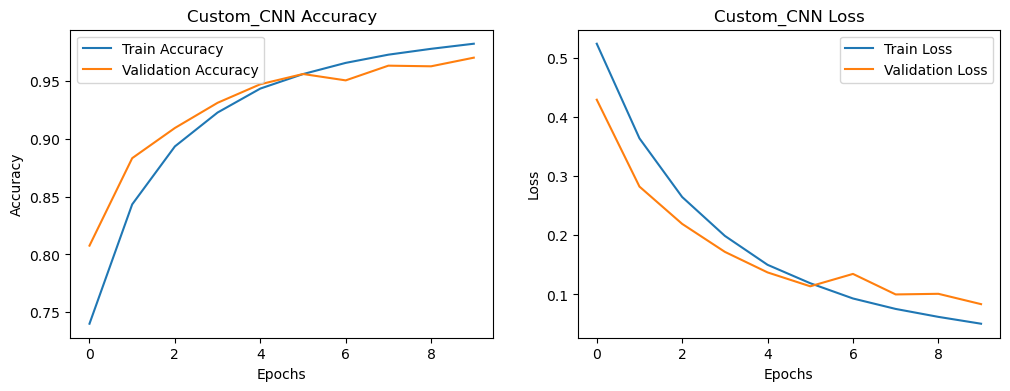

In [10]:
for model_name, history in history_dict.items():
    plot_performance(history, model_name)

# 7. Model Evaluation on Test Images

In [11]:
def predict_image(model, img_path):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)[0][0]
    
    plt.imshow(img)
    plt.axis('off')
    label = "Fake" if prediction > 0.5 else "Real"
    plt.title(f"Prediction: {label} ({prediction:.2f})")
    plt.show()

In [15]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# model_path = "models/ResNet5.keras"  
model_path = "models/Custom_CNN.keras" 
model = load_model(model_path)

# Get predictions on test data
y_pred = model.predict(test_generator)
y_pred = np.where(y_pred > 0.5, 1, 0)  

# Get true labels
y_true = test_generator.classes

# Print classification report (Precision, Recall, F1-Score, Accuracy)
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))


625/625 [==============================] - 51s 81ms/step
              precision    recall  f1-score   support

        Real       0.98      0.96      0.97     10000
        Fake       0.96      0.98      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



# Test with sample images